### Step1: Load uber pickups NYC dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Step 1: Load and Preprocess Uber Dataset
file_path = 'all_uber.csv'  # Download from URL above
data = pd.read_csv(file_path)

# Change to numerical timestamp
data['datetime'] = pd.to_datetime(data['Date/Time'])
min_dt = data['datetime'].min()
data['timestamp'] = (data['datetime'] - min_dt).dt.total_seconds()
data = data[['timestamp', 'Lat', 'Lon', 'Base']].dropna()  # Ignore Base for now
full_data_size = len(data)
print(f"Dataset loaded: {full_data_size} rows")

# Dimensions for ranges (3D: time + spatial bbox)
dimensions = ['timestamp', 'Lat', 'Lon']

print(data.head())

Dataset loaded: 4534327 rows
   timestamp      Lat      Lon    Base
0      660.0  40.7690 -73.9549  B02512
1     1020.0  40.7267 -74.0345  B02512
2     1260.0  40.7316 -73.9873  B02512
3     1680.0  40.7588 -73.9776  B02512
4     1980.0  40.7594 -73.9722  B02512


### Step2: Create a Small Offline Sample

In [3]:
# Step 2: Create Small Offline Sample
sample_size = int(0.01 * full_data_size)  # ~5k rows
sample = data.sample(n=sample_size, random_state=42).copy()
print(f"Sample created: {sample.shape[0]} rows")
print(sample.head())

Sample created: 45343 rows
          timestamp      Lat      Lon    Base
255777     850500.0  40.7588 -73.9726  B02617
2591794   7138080.0  40.8451 -73.9418  B02617
1384006  12956280.0  40.7399 -73.9823  B02764
530592    2392200.0  40.6449 -73.7824  B02682
3679163  14676000.0  40.7636 -73.9798  B02598


### Step 3: Generate Query Log, training data, testing data, optimize testing data.

Chapter 6.1: "In order to avoid most of the multi-dimensional query results to be zero, we limit the range to generate the boundaries in each dimension. The left boundary of the range in each dimension is randomly chosen from the first quarter of the entire value range of the corresponding attribute. Similarly, each right boundary is randomly chosen from the last quarter of the corresponding attribute range."

In [4]:
from query_generate import generate_random_query

q = generate_random_query(data, dimensions, test = True)
print(q)

dim: timestamp, min value: 0.0, max value: 15807540.0
dim: Lat, min value: 39.6569, max value: 42.1166
dim: Lon, min value: -74.929, max value: -72.0666
{'timestamp': (2246216.6691679973, 14833980.873215703), 'Lat': (40.12602911126217, 42.03516249660105), 'Lon': (-74.3253939330627, -72.20031201333275)}


Build query log (about 3mins), the main task is COUNT.

In [5]:
from query_generate import generate_query_log

query_log = generate_query_log(2000, data, sample, dimensions, full_data_size)

Generated 2000 queries


In [6]:
# Check any query in query log.
query_log[100]

{'query': {'timestamp': (1504296.298244958, 12528881.206575815),
  'Lat': (39.87590876497042, 42.0918361253013),
  'Lon': (-74.88040920537189, -72.29543121623188)},
 'exact': 2996043,
 'estimate': 3026018.0186577863,
 'error': -29975.018657786306}

Build training data with diversification.

In [7]:
from diversification import diversify_query_log

training_data_query_log = diversify_query_log(query_log, dimensions, k=800)

Diversified query log: selected 800 / 2000 entries


In [8]:
# CHeck any query in diversify query log.
training_data_query_log[160]

{'query': {'timestamp': (1796123.0281812483, 15699022.787853012),
  'Lat': (39.9063662133739, 41.75442749647555),
  'Lon': (-74.84334303288985, -72.15547223434409)},
 'exact': 4128217,
 'estimate': 4130524.5955274245,
 'error': -2307.595527424477}

Graph of before diversification and after.

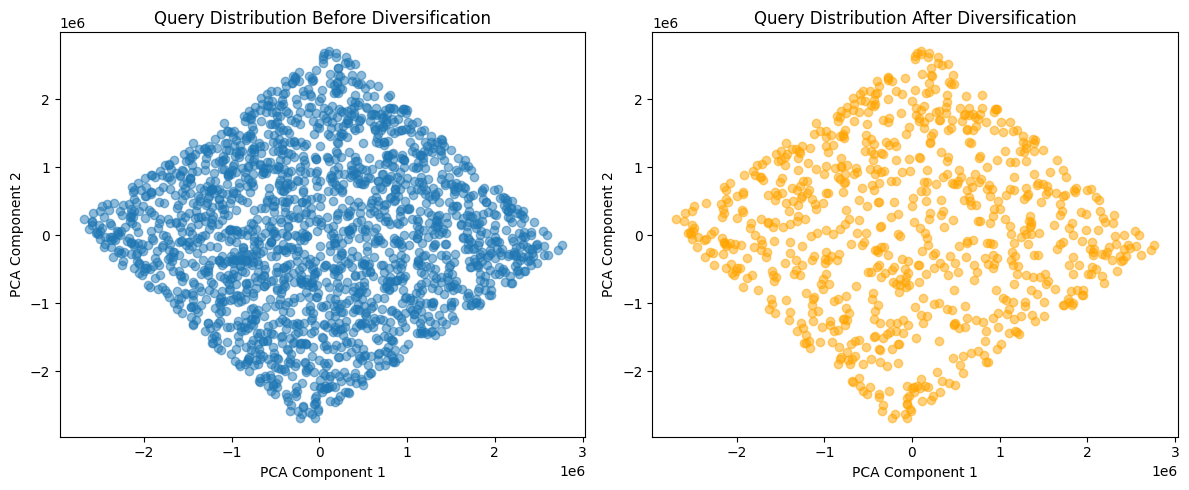

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from visualization import extract_features

# Extract features for original and diversified
original_features = extract_features(query_log, dimensions)
diversified_features = extract_features(training_data_query_log, dimensions)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_features)
diversified_pca = pca.transform(diversified_features)  # Use same PCA

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before diversification
axes[0].scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5)
axes[0].set_title('Query Distribution Before Diversification')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# After diversification
axes[1].scatter(diversified_pca[:, 0], diversified_pca[:, 1], alpha=0.5, color='orange')
axes[1].set_title('Query Distribution After Diversification')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

Build testing data.

In [10]:
testing_data_query_log = generate_query_log(100, data, sample, dimensions, full_data_size)

Generated 100 queries


Check training, testing data size.

In [11]:
print("Training data: ", len(training_data_query_log), "\nTesting data: ",  len(testing_data_query_log))

Training data:  800 
Testing data:  100


### Step 4: Train the Error Prediction Model

Load model if needed.

In [ ]:
# import joblib

# data = joblib.load("regression_pipeline.pkl")
# model = data["model"]
# scaler = data["scaler"]

Train model.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Train Error Model on Diversified Log
X = [[entry['query'][dim][i] for dim in dimensions for i in range(2)] for entry in training_data_query_log]
y = [entry['error'] for entry in training_data_query_log]
X = np.array(X)
y = np.array(y)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_scaled, y)
print("Model trained")

# Evaluate model using MSE.
# train_mse = np.mean((model.predict(X) - y) ** 2)
# test_mse  = np.mean((model.predict(X_test)  - y_test)  ** 2)
# print(f"Train MSE: {train_mse}")
# print(f"Test  MSE: {test_mse}")


Model trained


### Step 5: Estimate a New Query

In [13]:
q = generate_random_query(data, dimensions, test = True)
print(q)

dim: timestamp, min value: 0.0, max value: 15807540.0
dim: Lat, min value: 39.6569, max value: 42.1166
dim: Lon, min value: -74.929, max value: -72.0666
{'timestamp': (3276547.182835968, 12352454.0122536), 'Lat': (39.85518371446951, 41.874804671734985), 'Lon': (-74.38124312399275, -72.48801059371775)}


In [15]:
from query_calculate import sample_count, exact_count
# Example Query
new_query = {
    'timestamp': (5000000, 15000000),  # e.g., April 1-2, 2014 (Unix seconds)
    'Lat': (40.7, 42.0),
    'Lon': (-74.5, -73.9)
}

# Flatten and scale
new_vec = []
for dim in dimensions:
    lower, upper = new_query[dim]
    new_vec.extend([lower, upper])
new_vec = np.array([new_vec])
new_scaled = scaler.transform(new_vec)

# Predict error
predicted_error = model.predict(new_scaled)[0]

# Find error-similar historical query (closest error)
min_diff = float('inf')
opt_entry = None
for entry in training_data_query_log:
    error_diff = abs(entry['error'] - predicted_error)
    if error_diff < min_diff:
        min_diff = error_diff
        opt_entry = entry

# Compute final estimate
sample_new = sample_count(new_query, sample, full_data_size)
sample_opt = opt_entry['estimate']
final_estimate = opt_entry['exact'] + (sample_new - sample_opt)

print(f"LAQP estimate: {final_estimate:.2f}")
# Compute exact for the same query (for debugging/small queries)
exact = exact_count(new_query, data)
print(f"Exact count: {exact:.2f}")
print(f"Relative error: {abs(final_estimate - exact) / exact:.4f}")

# Also see how many rows match
# mask = np.ones(len(data), dtype=bool)
# for dim, (l, u) in new_query.items():
#     mask &= (data[dim] >= l) & (data[dim] <= u)
# matched_rows = mask.sum()
# print(f"Query matches {matched_rows:,} rows ({matched_rows / len(data):.1%} of dataset)")

LAQP estimate: 2580774.70
Exact count: 2574983.00
Relative error: 0.0022


In [ ]:
from estimation import laqp_estimate_with_details
# Use it
estimate, opt_idx, opt_entry = laqp_estimate_with_details(training_data_query_log, new_query, sample, dimensions, model, scaler, full_data_size)

Selected optimal query index: 178 (out of  800)
Predicted error for new query: 211.95
Chosen historical query error: 259.33 (diff: 47.39)


### Step 6: Evaluate and Extend

Optimization


In [ ]:
from optimization import optimize_alpha, range_distance

best_alpha = optimize_alpha(training_data_query_log, testing_data_query_log, dimensions, scaler, model, sample, full_data_size)

Optimized alpha: 0.764 (MSE on val: 0.0003)


In [18]:
from estimation import optimized_laqp_estimate

# Basic (error-only, like laqp_estimate_with_details)
basic_est, basic_idx, basic_entry = laqp_estimate_with_details(new_query)  # Already does error-only

# Optimized (hybrid with best_alpha)
opt_est, opt_entry = optimized_laqp_estimate(training_data_query_log, new_query, sample, dimensions, model, scaler, full_data_size, best_alpha)

# Compare
exact = exact_count(new_query, data)  # Or use exact_sum if needed
print(f"\nExact: {exact}")
print(f"Basic rel error: {abs(basic_est - exact) / exact:.4f}")
print(f"Optimized rel error: {abs(opt_est - exact) / exact:.4f}")

Selected optimal query index: 178 (out of  800)
Predicted error for new query: 211.95
Chosen historical query error: 259.33 (diff: 47.39)
Optimized LAQP estimate: 2571676.93
Chosen historical error: -8838.43

Exact: 2574983
Basic rel error: 0.0022
Optimized rel error: 0.0013


In [20]:
# Evaluation on testing_data_query_log (assume it's your 100 test queries)
laqp_rel_errors = []
sampling_rel_errors = []
laqp_squared_errors = []
sampling_squared_errors = []
laqp_abs_errors = []
sampling_abs_errors = []

min_exact_threshold = 100  # For COUNT: skip if exact count <100 (adjust as needed)
avg_exact = np.mean([tq['exact'] for tq in testing_data_query_log])
print(f"Avg exact COUNT: {avg_exact:.2f}")
filtered_count = 0

for tq in testing_data_query_log:
    query = tq['query']
    exact = tq['exact']
    
    if exact < min_exact_threshold:
        continue
    filtered_count += 1
    
    # Pure Sampling Estimate
    sample_est = sample_count(query, sample, full_data_size)
    sampling_abs = abs(sample_est - exact)
    sampling_rel = sampling_abs / exact if exact > 0 else 0
    sampling_sq = (sample_est - exact)**2
    
    sampling_abs_errors.append(sampling_abs)
    sampling_rel_errors.append(sampling_rel)
    sampling_squared_errors.append(sampling_sq)
    
    # LAQP Estimate (with Hybrid)
    vec = [query[dim][i] for dim in dimensions for i in range(2)]
    vec = np.array([vec])
    scaled = scaler.transform(vec)
    pred_error = model.predict(scaled)[0]
    best_entry = min(training_data_query_log, key=lambda e:
        best_alpha * abs(e['error'] - pred_error) + 
        (1 - best_alpha) * range_distance(dimensions, query, e['query']))
    sample_new = sample_count(query, sample, full_data_size)
    sample_opt = best_entry['estimate']
    laqp_est = best_entry['exact'] + (sample_new - sample_opt)
    
    laqp_abs = abs(laqp_est - exact)
    laqp_rel = laqp_abs / exact if exact > 0 else 0
    laqp_sq = (laqp_est - exact)**2
    
    laqp_abs_errors.append(laqp_abs)
    laqp_rel_errors.append(laqp_rel)
    laqp_squared_errors.append(laqp_sq)

# Results
print("\n==================================================")
print("EVALUATION RESULTS")
print("==================================================")
print(f"Evaluated on {filtered_count} / {len(testing_data_query_log)} queries "
      f"(excluded {len(testing_data_query_log)-filtered_count} tiny ones)")

if len(laqp_rel_errors) > 0:
    laqp_are = np.mean(laqp_rel_errors)
    sampling_are = np.mean(sampling_rel_errors)
    laqp_mse = np.mean(laqp_squared_errors)
    sampling_mse = np.mean(sampling_squared_errors)
    laqp_mae = np.mean(laqp_abs_errors)
    sampling_mae = np.mean(sampling_abs_errors)
    
    print(f"\nLAQP    Average Relative Error (ARE): {laqp_are:.4f}")
    print(f"LAQP    Median Relative Error:       {np.median(laqp_rel_errors):.4f}")
    print(f"LAQP    Mean Squared Error (MSE):    {laqp_mse:.2f}")
    print(f"LAQP    Mean Absolute Error (MAE):   {laqp_mae:.2f}")
    
    print(f"\nSampling ARE:                       {sampling_are:.4f}")
    print(f"Sampling Median Relative Error:     {np.median(sampling_rel_errors):.4f}")
    print(f"Sampling MSE:                       {sampling_mse:.2f}")
    print(f"Sampling MAE:                       {sampling_mae:.2f}")
    
    improvement = sampling_are / laqp_are if laqp_are > 0 else 0
    print(f"\nImprovement (Sampling ARE / LAQP ARE): {improvement:.2f}x")
else:
    print("No queries passed the threshold — lower min_exact_threshold")

Avg exact COUNT: 3412100.63

EVALUATION RESULTS
Evaluated on 100 / 100 queries (excluded 0 tiny ones)

LAQP    Average Relative Error (ARE): 0.0003
LAQP    Median Relative Error:       0.0002
LAQP    Mean Squared Error (MSE):    1501962.91
LAQP    Mean Absolute Error (MAE):   966.99

Sampling ARE:                       0.0057
Sampling Median Relative Error:     0.0064
Sampling MSE:                       432118214.23
Sampling MAE:                       18427.31

Improvement (Sampling ARE / LAQP ARE): 19.48x


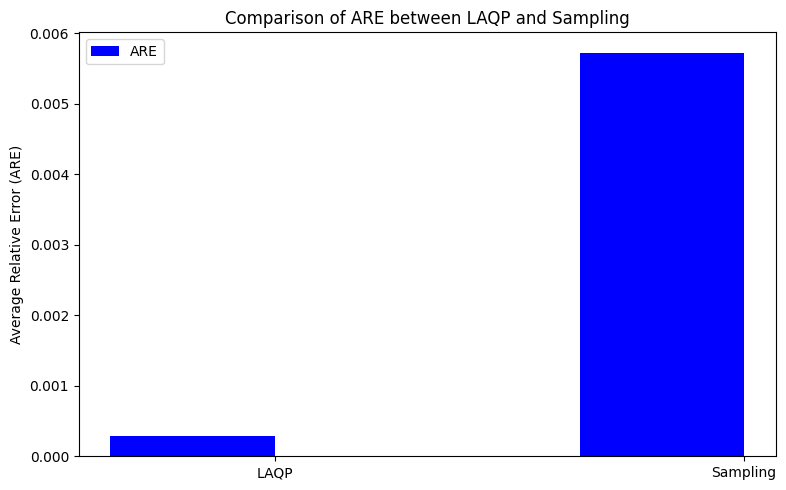

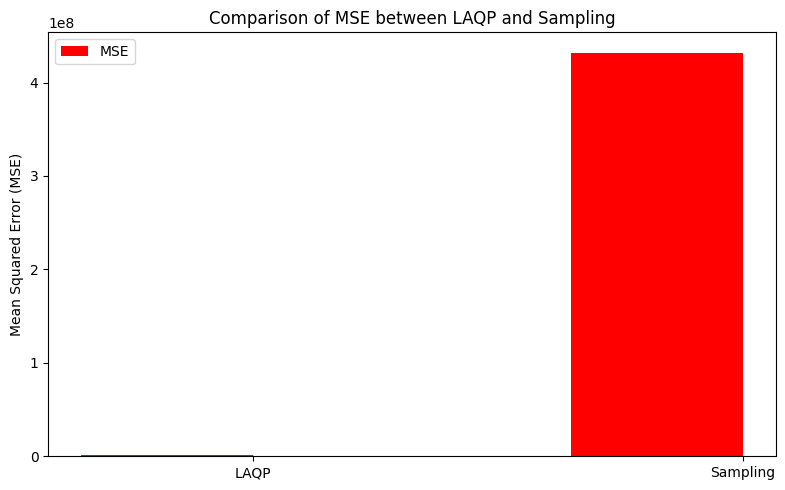

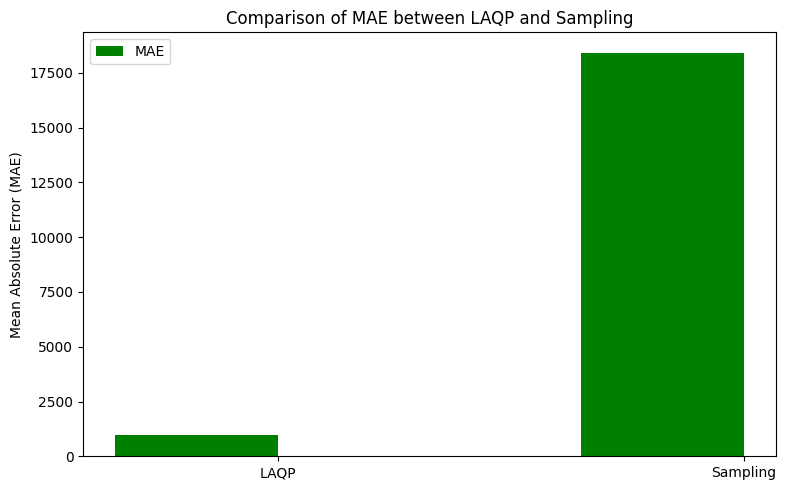

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Use computed metrics from above
methods = ['LAQP', 'Sampling']
are_values = [laqp_are, sampling_are]
mse_values = [laqp_mse, sampling_mse]
mae_values = [laqp_mae, sampling_mae]

# Bar chart for ARE
fig, ax1 = plt.subplots(figsize=(8, 5))
x = np.arange(len(methods))
width = 0.35
ax1.bar(x - width/2, are_values, width, label='ARE', color='blue')
ax1.set_ylabel('Average Relative Error (ARE)')
ax1.set_title('Comparison of ARE between LAQP and Sampling')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Bar chart for MSE
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(x - width/2, mse_values, width, label='MSE', color='red')
ax2.set_ylabel('Mean Squared Error (MSE)')
ax2.set_title('Comparison of MSE between LAQP and Sampling')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Bar chart for MAE (bonus)
fig, ax3 = plt.subplots(figsize=(8, 5))
ax3.bar(x - width/2, mae_values, width, label='MAE', color='green')
ax3.set_ylabel('Mean Absolute Error (MAE)')
ax3.set_title('Comparison of MAE between LAQP and Sampling')
ax3.set_xticks(x)
ax3.set_xticklabels(methods)
ax3.legend(loc='upper left')
plt.tight_layout()
plt.show()

Save if needed.

In [ ]:
import joblib

joblib.dump({
    "model": model,
    "scaler": scaler,
    "alpha": best_alpha,
    "training_query": training_data_query_log,
    "sample": sample
}, "12_23_uber.pkl")